In [1]:
# IMPORTS & ENV SETUP
import os                                  
import math                                
import random
import time                             
import numpy as np                        
import torch                          
import torch.nn as nn                             
from torch.utils.data import DataLoader   
from torch.utils.data import TensorDataset
from torchvision import datasets         
from torchvision import transforms         
import matplotlib.pyplot as plt     
import warnings
warnings.filterwarnings("ignore"),

print(f"Torch version: {torch.__version__}")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

Torch version: 2.9.1+cpu
Using device: cpu
C:\term_project


In [2]:
# LOAD MODEL FROM Q1 AND SETUP

MODELS_DIR = './models'
MODEL_PATH = os.path.join(MODELS_DIR, 'best_model_fnn.pth')

# Define the model architecture (same as Q1)
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_p=0.1):
        super(FeedForwardNN, self).__init__()
        
        # Create a list of layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Model parameters
INPUT_SIZE = 32 * 32
HIDDEN_SIZES = [512, 256, 128]
NUM_CLASSES = 10

# Load the saved model
device = torch.device('cpu')
model = FeedForwardNN(INPUT_SIZE, HIDDEN_SIZES, NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"Model loaded from {MODEL_PATH}")

Model loaded from ./models\best_model_fnn.pth


In [3]:
# LOAD TEST DATASET 

DATA_DIR = './data'
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=False, 
    transform=transform)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

print(f"Test dataset loaded with {len(test_dataset)} samples.")

Test dataset loaded with 10000 samples.


In [4]:
# HELPER FUNCTION TO EVALUATE ACCURACY

def evaluate_accuracy(loader, model):
    """
    Evaluate the accuracy of the model on the given data loader.
    Args:
        loader (DataLoader): DataLoader for the dataset to evaluate.
        model (torch.nn.Module): The model to evaluate.
    Returns:
        float: Accuracy percentage of the model on the dataset.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Original test accuracy
original_acc = evaluate_accuracy(test_loader, model)
print(f"Original Test Accuracy: {original_acc:.2f}%")

Original Test Accuracy: 45.23%


In [5]:
# TEST PARAMETERS

# Since we have 32x32=1024 pixels, we can vary the number of pixels to fuzz (100, 200, 400, 600, 1024)
# (mu, sigma, num_pixels)
PIXEL_PGF_CONFIG = [
    (0, 0.5, 100), 
    (0, 0.8, 100), 
    (0, 1.0, 200), 
    (0, 0.5, 200), 
    (0, 0.8, 400), 
    (0, 1.0, 400),
    (-0.1, 0.5, 600), 
    (-0.1, 0.9, 600),
    (0, 0.5, 1024),
    (0.2, 1, 1024)] 

# This will used on model weight fuzzing, we only vary mu and sigma (all weights)
# (mu, sigma)
WEIGHTS_PGF_CONFIG = [
    (0, 0.5),
    (0, 0.8),
    (0, 1.0),
    (0.1, 0.5),
    (0.1, 0.8),
    (0.1, 1.0),
    (-0.1, 0.5),
    (-0.1, 0.9)] 


PART A: Pixel Gauss Fuzzing on Test Dataset

Original Image - Label: automobile


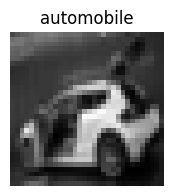


Applying PGF with μ=0, σ=0.5, num_pixels=100


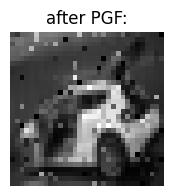

PGF (μ=0, δ=0.5): Accuracy 44.87%, Misclassification 55.13%

Applying PGF with μ=0, σ=0.8, num_pixels=100


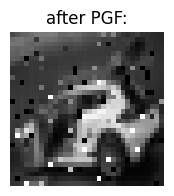

PGF (μ=0, δ=0.8): Accuracy 44.62%, Misclassification 55.38%

Applying PGF with μ=0, σ=1.0, num_pixels=200


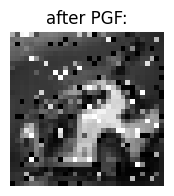

PGF (μ=0, δ=1.0): Accuracy 42.78%, Misclassification 57.22%

Applying PGF with μ=0, σ=0.5, num_pixels=200


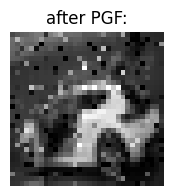

PGF (μ=0, δ=0.5): Accuracy 44.35%, Misclassification 55.65%

Applying PGF with μ=0, σ=0.8, num_pixels=400


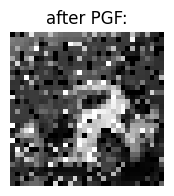

PGF (μ=0, δ=0.8): Accuracy 41.42%, Misclassification 58.58%

Applying PGF with μ=0, σ=1.0, num_pixels=400


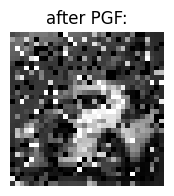

PGF (μ=0, δ=1.0): Accuracy 39.37%, Misclassification 60.63%

Applying PGF with μ=-0.1, σ=0.5, num_pixels=600


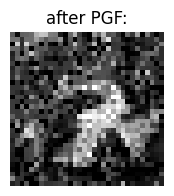

PGF (μ=-0.1, δ=0.5): Accuracy 42.22%, Misclassification 57.78%

Applying PGF with μ=-0.1, σ=0.9, num_pixels=600


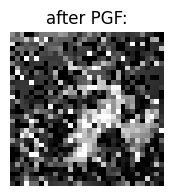

PGF (μ=-0.1, δ=0.9): Accuracy 37.99%, Misclassification 62.01%

Applying PGF with μ=0, σ=0.5, num_pixels=1024


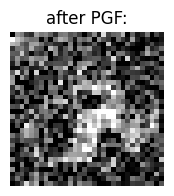

PGF (μ=0, δ=0.5): Accuracy 39.71%, Misclassification 60.29%

Applying PGF with μ=0.2, σ=1, num_pixels=1024


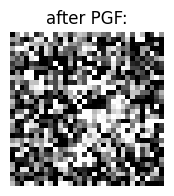

PGF (μ=0.2, δ=1): Accuracy 28.27%, Misclassification 71.73%


In [16]:
# PART A: Pixel Gauss Fuzzing (PGF)

# How PGF works?
# Pixel Gauss Fuzzing (PGF) works by adding Gaussian noise to a randomly selected subset of pixels in the input images.
# This simulates noise or corruption in the input data, testing the model's robustness.

def apply_pgf(images, mu=0, sigma=0.8, num_pixels=100):
    """
    Apply Pixel Gauss Fuzzing: Add Gaussian noise to randomly selected pixels.
    """
    fuzzed_images = images.clone()
    batch_size, channels, height, width = fuzzed_images.shape
    
    for b in range(batch_size):
        # Randomly select pixels
        indices = np.random.choice(height * width, num_pixels, replace=False)
        
        for idx in indices:
            h = idx // width # Row index
            w = idx % width # Column index
            noise = np.random.normal(mu, sigma)
            fuzzed_images[b, 0, h, w] += noise  # Add noise to the selected pixel
            # Clip to [-1, 1] since normalized
            fuzzed_images[b, 0, h, w] = torch.clamp(fuzzed_images[b, 0, h, w], -1, 1)
    
    return fuzzed_images


print("\nPART A: Pixel Gauss Fuzzing on Test Dataset")

# Select a fixed image for visualization
selected_idx = 6
original_image, original_label = test_dataset[selected_idx]
original_image_display = original_image.squeeze().numpy()
print(f"\nOriginal Image - Label: {test_dataset.classes[original_label]}")

# Visualize the original image
plt.figure(figsize=(2, 2))
plt.imshow(original_image_display, cmap='gray')
plt.title(f'{test_dataset.classes[original_label]}')
plt.axis('off')
plt.show()
plt.close()

# Test different (mu, sigma, num_pixels) for pixel fuzzing
for mu, sigma, num_pixels in PIXEL_PGF_CONFIG:
    print(f"\nApplying PGF with μ={mu}, σ={sigma}, num_pixels={num_pixels}")

    # Apply fuzzing to the selected image
    selected_image_tensor = original_image.unsqueeze(0)  # Add batch dim
    fuzzed_selected = apply_pgf(selected_image_tensor, mu, sigma, num_pixels)
    fuzzed_display = fuzzed_selected.squeeze().numpy()

    # Visualize the fuzzed image
    plt.figure(figsize=(2, 2))
    plt.imshow(fuzzed_display, cmap='gray')
    plt.title(f'after PGF:')
    plt.axis('off')
    plt.show()
    plt.close()

    # Create fuzzed test loader
    fuzzed_dataset = []
    
    # Apply PGF to each batch
    for images, labels in test_loader:
        fuzzed_images = apply_pgf(images, mu, sigma, num_pixels)
        fuzzed_dataset.extend(zip(fuzzed_images, labels))
    
    # Since DataLoader expects dataset, create a simple list dataset
    fuzzed_images_list, labels_list = zip(*fuzzed_dataset)
    fuzzed_images_tensor = torch.stack(fuzzed_images_list)
    labels_tensor = torch.tensor(labels_list)
    fuzzed_test_dataset = TensorDataset(fuzzed_images_tensor, labels_tensor)
    fuzzed_test_loader = DataLoader(fuzzed_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    acc = evaluate_accuracy(fuzzed_test_loader, model)
    misclass_rate = 100 - acc
    
    print(f"PGF (μ={mu}, δ={sigma}): Accuracy {acc:.2f}%, Misclassification {misclass_rate:.2f}%")

In [17]:
# PART B: Gauss Fuzzing on Model Weights

def apply_weight_fuzzing(model, mu=0, sigma=0.1):
    """
    Apply Gauss Fuzzing to model weights.
    """
    fuzzed_model = FeedForwardNN(INPUT_SIZE, HIDDEN_SIZES, NUM_CLASSES).to(device)
    fuzzed_model.load_state_dict(model.state_dict())  # Copy original
    with torch.no_grad():
        for param in fuzzed_model.parameters():
            if param.requires_grad:  # Only weights, not biases necessarily, but all params
                noise = torch.normal(mu, sigma, size=param.shape).to(device)
                param.add_(noise)
    return fuzzed_model

print("\nPART B: Weight Gauss Fuzzing Results")
for mu, sigma in WEIGHTS_PGF_CONFIG:
    print(f"\nApplying Weight Fuzzing with μ={mu}, σ={sigma}")
    
    fuzzed_model = apply_weight_fuzzing(model, mu, sigma)
    acc = evaluate_accuracy(test_loader, fuzzed_model)
    misclass_rate = 100 - acc
    print(f"Weight Fuzzing (μ={mu}, δ={sigma}): Accuracy {acc:.2f}%, Misclassification {misclass_rate:.2f}%")


PART B: Weight Gauss Fuzzing Results

Applying Weight Fuzzing with μ=0, σ=0.5
Weight Fuzzing (μ=0, δ=0.5): Accuracy 10.99%, Misclassification 89.01%

Applying Weight Fuzzing with μ=0, σ=0.8
Weight Fuzzing (μ=0, δ=0.8): Accuracy 9.69%, Misclassification 90.31%

Applying Weight Fuzzing with μ=0, σ=1.0
Weight Fuzzing (μ=0, δ=1.0): Accuracy 9.82%, Misclassification 90.18%

Applying Weight Fuzzing with μ=0.1, σ=0.5
Weight Fuzzing (μ=0.1, δ=0.5): Accuracy 9.96%, Misclassification 90.04%

Applying Weight Fuzzing with μ=0.1, σ=0.8
Weight Fuzzing (μ=0.1, δ=0.8): Accuracy 8.77%, Misclassification 91.23%

Applying Weight Fuzzing with μ=0.1, σ=1.0
Weight Fuzzing (μ=0.1, δ=1.0): Accuracy 8.97%, Misclassification 91.03%

Applying Weight Fuzzing with μ=-0.1, σ=0.5
Weight Fuzzing (μ=-0.1, δ=0.5): Accuracy 10.13%, Misclassification 89.87%

Applying Weight Fuzzing with μ=-0.1, σ=0.9
Weight Fuzzing (μ=-0.1, δ=0.9): Accuracy 8.22%, Misclassification 91.78%


In [ ]:
# FINAL COMMENTS

# From the results of Pixel Gauss Fuzzing (PGF) and Weight Gauss Fuzzing, we can observe how different types of noise affect the model's performance.
# PGF directly alters the input data, simulating real-world noise, while weight fuzzing tests the model's internal robustness.
# Generally, as the intensity of noise (higher sigma) or the number of affected pixels increases, the model's accuracy tends to decrease, indicating its sensitivity to such perturbations.